<a href="https://colab.research.google.com/github/Leonard2310/TrendAnalysis/blob/main/code/LSTMforStreamlitISBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training del Modello LSTM per le Previsioni
Si è scelto di addestrare e salvare un nuovo modello LSTM, progettato per essere utilizzato nella fase successiva all'interno della dashboard Streamlit. Questo modello consente di effettuare previsioni in tempo reale sulle catture di insetti, basandosi sui dati meteorologici storici di una città selezionata dinamicamente dall'utente.

# Drive Linking
È stato effettuato un collegamento al Drive per il caricamento dei dati direttamente dal cloud.

In [1]:
from google.colab import drive                                                  # Import the Google Colab Drive module

drive.mount('/content/drive')                                                   # Base address of the drive

Mounted at /content/drive


# Library
Importazione delle librerie necessarie al corretto funzionamento del codice.

In [2]:
!pip install tensorflow==2.16.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.16.2 w

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler


# Per i modelli di machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

# Integrazione con Google Drive (se si usa Google Colab)
from google.colab import drive

# Data Import
Per l'addestramento del modello, è stato utilizzato un dataset proveniente da progetti di anni precedenti, caratterizzato da una maggiore quantità di dati disponibili. Questa scelta è stata motivata dalla necessità di garantire un addestramento più robusto e consistente, ottimizzando così la capacità del modello di fornire previsioni accurate e affidabili.

In [4]:
!wget -O temp_humid_data.xlsx https://www.dropbox.com/scl/fi/326oxe283ly6tgtfqrf3p/temp_humid_data.xlsx?rlkey=e1errsfubga1jauvr9g6z8j3j&st=5v76nvon&dl=0

--2024-12-02 08:43:01--  https://www.dropbox.com/scl/fi/326oxe283ly6tgtfqrf3p/temp_humid_data.xlsx?rlkey=e1errsfubga1jauvr9g6z8j3j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45987e222abc25db89d0d60514.dl.dropboxusercontent.com/cd/0/inline/CfeUzr-S0SnUOarYTmhF3dl2DjQte0h7z9CJDSf11KEjmrNB-UYC8fnTbtGzGQkLYdlU7VHtuozJsKtGqOmCAR6Law_S-yQeUpAbWWlgpkAlL6YcwjEcQ7sW2a2o-dfxwbJym3Je6bWB7qEUGyLeEsAX/file# [following]
--2024-12-02 08:43:02--  https://uc45987e222abc25db89d0d60514.dl.dropboxusercontent.com/cd/0/inline/CfeUzr-S0SnUOarYTmhF3dl2DjQte0h7z9CJDSf11KEjmrNB-UYC8fnTbtGzGQkLYdlU7VHtuozJsKtGqOmCAR6Law_S-yQeUpAbWWlgpkAlL6YcwjEcQ7sW2a2o-dfxwbJym3Je6bWB7qEUGyLeEsAX/file
Resolving uc45987e222abc25db89d0d60514.dl.dropboxusercontent.com (uc45987e222abc25db89d0d60514.dl.dropboxusercontent.com)... 162.125.4.15

In [5]:
file_path = '/content/temp_humid_data.xlsx'

df = pd.read_excel(file_path, sheet_name=1)

df.to_csv("seasonal_data.csv")

In [6]:
df.index = df.Date
del df["Date"]

In [7]:
df

,no. of Adult males,temperature_mean,relativehumidity_mean
Date,,,
2023-06-15,1,24.62,45
2023-06-16,1,26.79,46
2023-06-17,0,26.02,53
2023-06-18,1,25.04,48
2023-06-19,0,25.09,43
...,...,...,...
2023-09-24,0,18.19,50
2023-09-25,2,17.75,73
2023-09-26,0,17.70,77


# LSTM Training
L'addestramento del modello è stato eseguito utilizzando un approccio mirato all'ottimizzazione dell'efficienza. In particolare, il tuning degli iperparametri è stato effettuato manualmente, con l'obiettivo di bilanciare la complessità del modello e le prestazioni computazionali, garantendo al contempo un processo di apprendimento efficace.

In [8]:
#@title Definition

def train_lstm_model(df, n_lags=5,  target_col='no. of Adult males',  exog_cols=[], learning_rate=0.001,  batch_size=8, epochs=25):
    # Creazione delle feature laggate
    def create_lagged_features(df, n_lags, target_col, exog_cols):
        lagged_df = df.copy()
        for col in [target_col] + exog_cols:
            for i in range(1, n_lags + 1):
                lagged_df[f'{col}_lag_{i}'] = lagged_df[col].shift(i)
        lagged_df = lagged_df.dropna()
        return lagged_df

    lagged_df = create_lagged_features(df, n_lags=n_lags, target_col=target_col, exog_cols=exog_cols)

    variables = [target_col] + exog_cols
    timestep_cols = []
    for t in range(n_lags):
        lag = n_lags - t
        cols = [f'{var}_lag_{lag}' for var in variables]
        timestep_cols.append(cols)

    # Creazione di X e y
    X_list = [lagged_df[cols].values for cols in timestep_cols]
    X = np.stack(X_list, axis=1)
    y = lagged_df[target_col].values

    train_size = len(lagged_df) - 5  # Split train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Scaling delle feature
    n_train_samples, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(n_train_samples, n_timesteps, n_features)
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], n_timesteps, n_features)

    # Definizione del modello
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.LSTM(50, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Addestramento del modello
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test),
        verbose=0
    )

    # Previsioni
    y_train_pred = model.predict(X_train_scaled).flatten()
    y_test_pred = model.predict(X_test_scaled).flatten()
    y_train_pred = np.clip(y_train_pred, 0, None).round()
    y_test_pred = np.clip(y_test_pred, 0, None).round()

    # Valutazione
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Residui
    residuals_train = y_train - y_train_pred

    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Grafico 1: Valori effettivi vs Predetti (Training)
    axs[0, 0].plot(y_train, label='Effettivi', color='blue', marker='o')
    axs[0, 0].plot(y_train_pred, label='Predetti', color='red', linestyle='--', marker='x')
    axs[0, 0].set_title(f'Training Data\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}')
    axs[0, 0].set_xlabel('Osservazioni')
    axs[0, 0].set_ylabel('No. di adulti maschi')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Grafico 2: Residui (Training)
    axs[0, 1].plot(residuals_train, label='Residui', color='purple', marker='o')
    axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[0, 1].set_title('Residui (Training)')
    axs[0, 1].set_xlabel('Osservazioni')
    axs[0, 1].set_ylabel('Residui')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Grafico 3: Perdita su Epoche
    axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[1, 0].set_title('Perdita durante le epoche')
    axs[1, 0].set_xlabel('Epoche')
    axs[1, 0].set_ylabel('Loss (MSE)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Grafico 4: Valori Effettivi vs Predetti (Test)
    axs[1, 1].plot(y_test, label='Effettivi', marker='o', color='blue')
    axs[1, 1].plot(y_test_pred, label='Predetti', marker='x', linestyle='--', color='red')
    axs[1, 1].set_title(f'Test Data\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
    axs[1, 1].set_xlabel('Osservazioni')
    axs[1, 1].set_ylabel('No. di adulti maschi')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, scaler, history, rmse_train, mae_train, rmse_test, mae_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


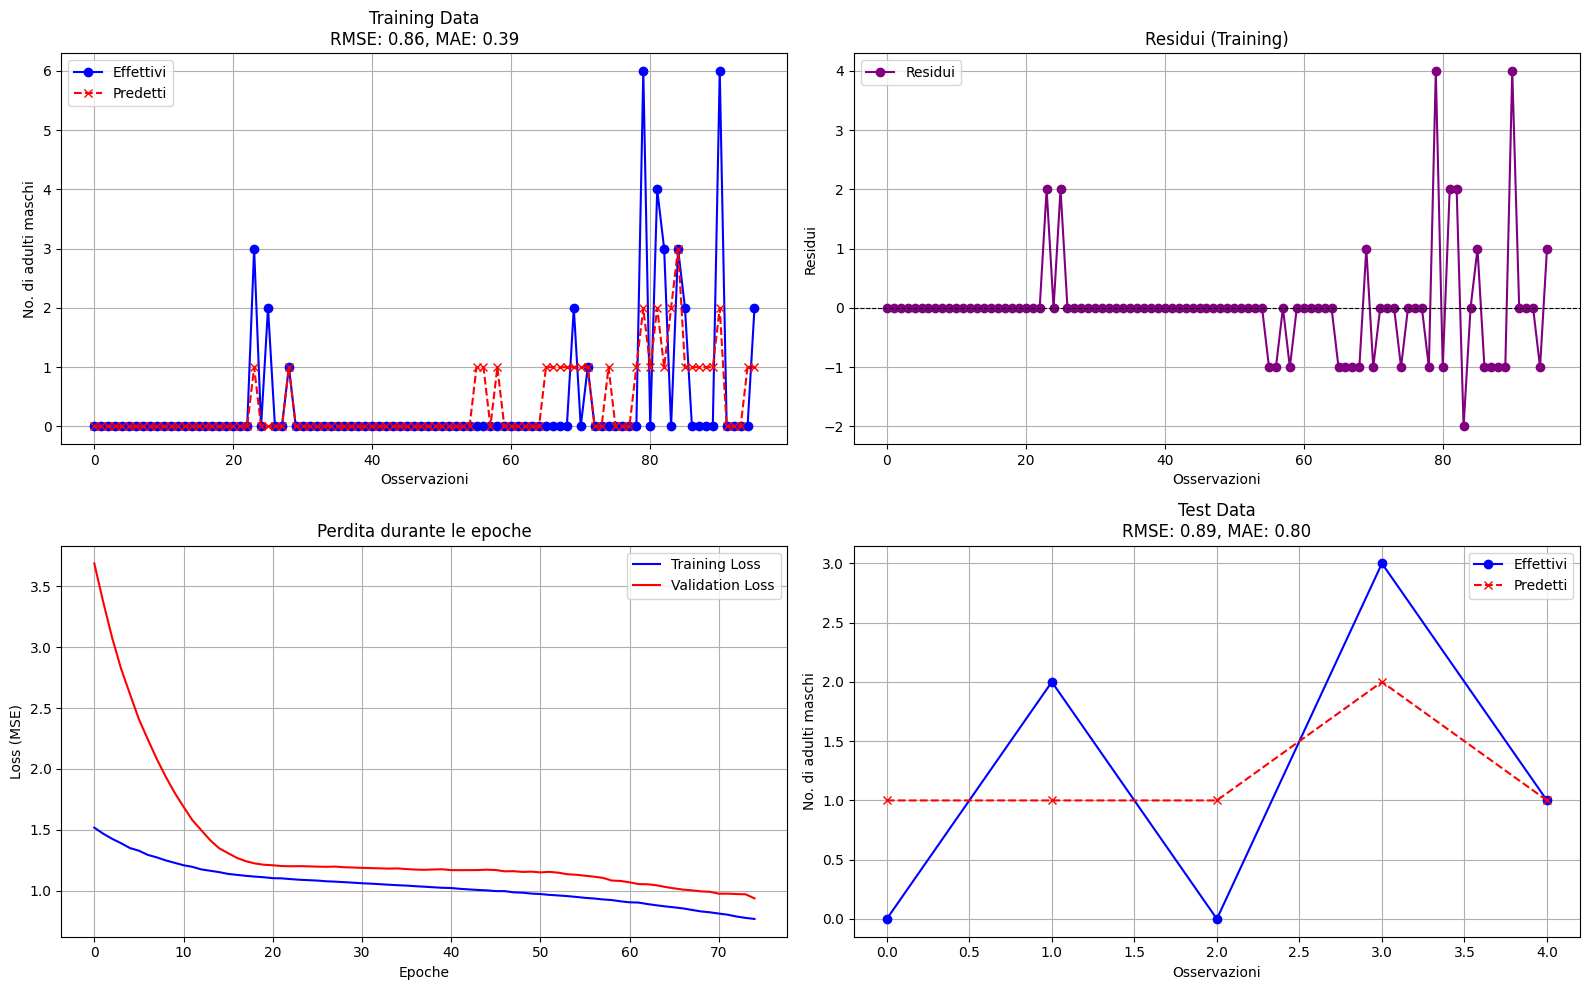

In [23]:
#@title Forecasting
model, scaler, history, rmse_train, mae_train, rmse_test, mae_test = train_lstm_model(
    df=df,
    n_lags=5,
    target_col='no. of Adult males',
    exog_cols=['temperature_mean', 'relativehumidity_mean'],
    learning_rate=0.0005,
    batch_size=20,
    epochs=75
)

# LSTM Saving
Il modello addestrato è stato salvato in formato Keras, consentendo il successivo caricamento e utilizzo senza la necessità di ripetere l'intero processo di addestramento. Questa scelta assicura una maggiore efficienza operativa e facilita l'integrazione del modello nelle fasi successive del progetto.

In [ ]:
model.save("lstm_model.keras")